In [1]:
import sys
import pickle
from pprint import pprint
import time
import datetime

In [2]:
from qiskit import IBMQ

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
backend = provider.get_backend("ibm_washington")
device = provider.backend.ibm_washington

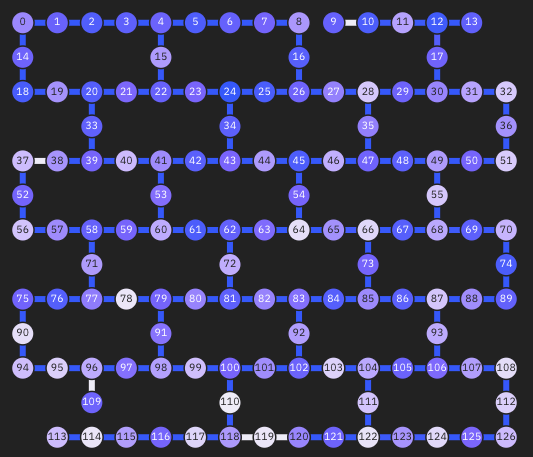

In [4]:
sys.path.append("../../libs_bell/")
from lib_graph_states import adjacency_list_for_cycle_graph, list_to_matrix, cycle_graph_state

In [5]:
vertex_list = list(range(0,13)) + [17] \
            + list(range(30,33)) + [36] \
            + list(range(49,52)[::-1]) + [55] \
            + list(range(68,71)) + [74] \
            + list(range(87,90)[::-1]) + [93] \
            + list(range(106,109)) + [112] \
            + list(range(122,127)[::-1]) + [111] \
            + list(range(100,105)[::-1]) + [110] \
            + list(range(114,119)[::-1]) + [109] \
            + list(range(94,97)[::-1]) + [90] \
            + list(range(75,86)) + [73] \
            + list(range(56,67)[::-1]) + [52] \
            + list(range(37,48)) + [35] \
            + list(range(18,29)[::-1]) + [14]
max_size = len(vertex_list) # largest graph size
initial_layout = vertex_list # [vertex_list[:n] for n in list(range(1, max_size + 1)] # initial_layouts
adj_list = adjacency_list_for_cycle_graph(max_size) # [adjacency_list_for_cycle_graph(n) for n in list(range(1, max_size + 1)] # adjacency list of graph size 1 to max_size
graph = list_to_matrix(adj_list) # [list_to_matrix(adj_list) for adj_list in adj_lists] # adjacency matrix of graph size 1 to max_size
shots_per_circuit = 1 << 13 # shots per one execution
print(vertex_list)
print("max_size:", max_size)
print("shots_per_circuit:", shots_per_circuit)
print("lengths of initial_layout:", len(initial_layout))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49, 55, 68, 69, 70, 74, 89, 88, 87, 93, 106, 107, 108, 112, 126, 125, 124, 123, 122, 111, 104, 103, 102, 101, 100, 110, 118, 117, 116, 115, 114, 109, 96, 95, 94, 90, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 73, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 52, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 35, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 14]
max_size: 104
shots_per_circuit: 8192
lengths of initial_layout: 104


In [6]:
from qiskit import QuantumCircuit
def cycle_graph_state(size, barrier=False, initial_layout = None, system_size = None):
    if size <= 1:
        qc = QuantumCircuit(size, size)
        return qc
    if initial_layout is None:
        initial_layout = list(range(size))
    graph_state = QuantumCircuit(system_size, size)
    graph_state.h(initial_layout)
    if barrier:
        graph_state.barrier()
    for i in [i for i in range(size) if i % 2 == 0][:-1]:
        graph_state.cz(initial_layout[i], initial_layout[i + 1])
    if size % 2 == 0: # terminal 
        graph_state.cz(initial_layout[size - 2], initial_layout[size - 1])
        graph_state.cz(initial_layout[size - 1], initial_layout[0])
    for i in [i for i in range(size) if i % 2 == 1][:-1]:
        graph_state.cz(initial_layout[i], initial_layout[i + 1])
    if size % 2 == 1: # terminal
        graph_state.cz(initial_layout[size - 2], initial_layout[size - 1])
        graph_state.cz(initial_layout[size - 1], initial_layout[0])
    return graph_state

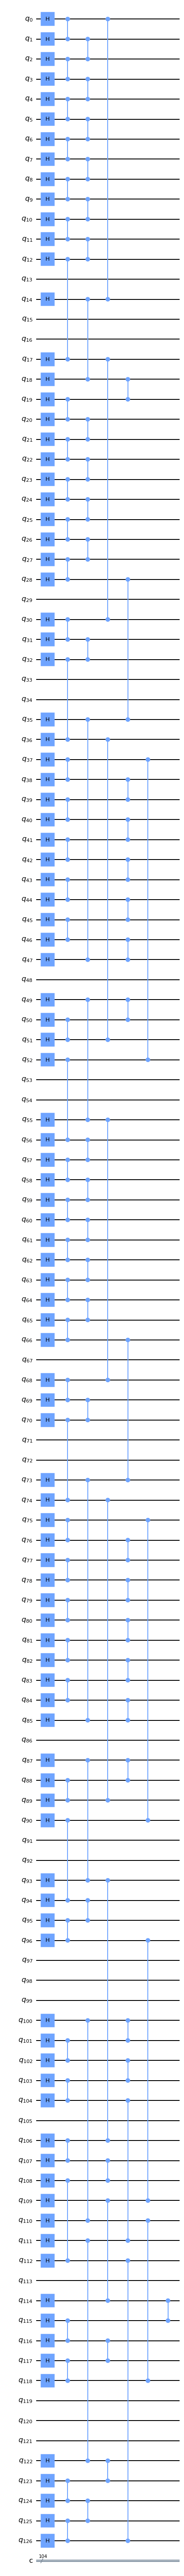

In [7]:
qc = cycle_graph_state(max_size, initial_layout=initial_layout, system_size=127)
qc.draw("mpl")

In [8]:
qcs_list = []

In [9]:
xz_meas = QuantumCircuit(127,max_size)
xz_meas.h(initial_layout[::2])
xz_meas.barrier()
xz_meas.measure(initial_layout, range(max_size))
qcs_list.append(qc.compose(xz_meas))
# qcs_list[0].draw("mpl")

In [10]:
zx_meas = QuantumCircuit(127,max_size)
zx_meas.h(initial_layout[1::2])
zx_meas.barrier()
zx_meas.measure(initial_layout, range(max_size))
qcs_list.append(qc.compose(zx_meas))
# qcs_list[1].draw("mpl")

In [11]:
calib_0 = QuantumCircuit(127,max_size)
calib_0.measure(initial_layout, range(max_size))
qcs_list.append(calib_0)
# qcs_list[2].draw("mpl")

In [12]:
calib_1 = QuantumCircuit(127,max_size)
calib_1.x(initial_layout)
calib_1.measure(initial_layout, range(max_size))
qcs_list.append(calib_1)
# qcs_list[3].draw("mpl")

In [13]:
len(qcs_list)

4

In [20]:
tqcs_list = []

In [23]:
from qiskit.compiler import transpile
for i in range(4):
    tqcs_list.append(transpile(qcs_list[i], optimization_level = 0, basis_gates=["rz", "sx", "cx"]))

In [24]:
len(tqcs_list)

4

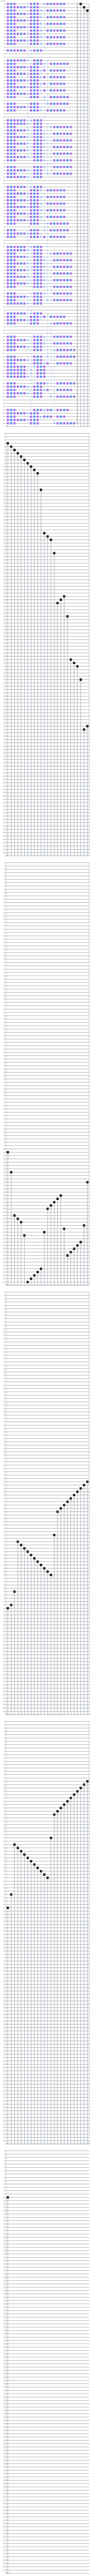

In [25]:
tqcs_list[0].draw("mpl")

In [27]:
from qiskit import assemble
qobj = assemble(tqcs_list)
job = backend.run(qobj)

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_67018/1272205316.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [14]:
# from lib_cycle_graphs import execute_circuits

In [15]:
# jobs = execute_circuits(qcs_list,
#                         backend=backend,
#                         shots=shots_per_circuit,
#                         max_experiments=900,
#                         optimization_level=0)
# print(len(jobs), "jobs")
# print("job_id:", jobs[0].job_id())

running on ibm_washington
circuits from 0 to 4 are put on the real device.
1 jobs
job_id: 6225de4aeee8dac90b567911


In [28]:
dt_now = datetime.datetime.now()
job_ids_filename = "job_ids_size_" + str(max_size) + "_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl"

In [29]:
with open("./pkls/" + job_ids_filename, "wb") as f:
    pickle.dump([job.job_id()], f)

In [30]:
with open("./pkls/" + "properties_" + dt_now.strftime('%Y%m%d_%H%M%S') + ".pkl", "wb") as f:
    pickle.dump(device.properties(), f)

In [ ]:
job.

UnboundLocalError: local variable 'grid_data' referenced before assignment

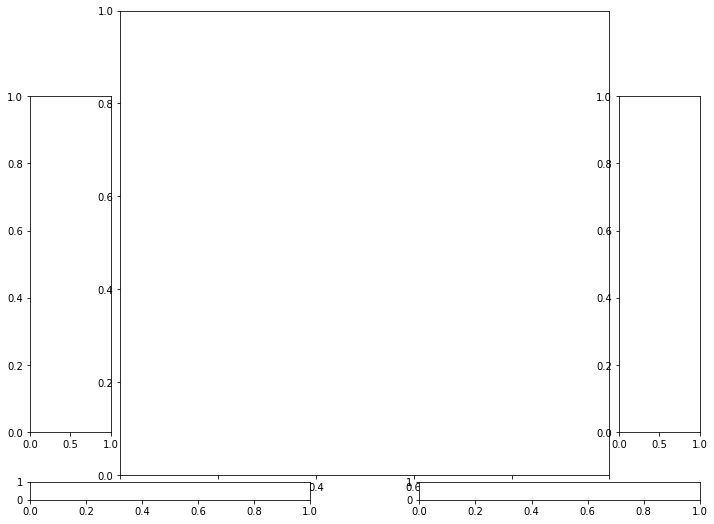

In [19]:
from qiskit.visualization import plot_error_map
plot_error_map(device)

In [ ]:
# qc = cycle_graph_state(max_size)
# from qiskit.visualization import plot_circuit_layout
# from qiskit import transpile
# qc_on_device = transpile(qc, backend=backend, optimization_level=1, initial_layout=vertex_list)
# plot_circuit_layout(qc_on_device, backend)